# RoBERTa for mnli

In [1]:
# Suppress all warnings from TensorFlow

import tensorflow as tf

tf.get_logger().setLevel('ERROR')


In [2]:
#import preprocessing, modeling, and evaluation libraries

import numpy as np
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments # changes made here
from sklearn.metrics import accuracy_score, classification_report
import torch

torch.cuda.empty_cache()


In [3]:
# loading training, validation and testing dataset

import pandas as pd

#training set
data_frame_train = pd.read_csv('./mnli dataset/sampled_training_data_ten_percent.csv')

#validation set
data_frame_validation = pd.read_csv('./mnli dataset/sampled_validation_data_ten_percent.csv')
                                    
#testing set                                  
data_frame_test = pd.read_csv('./mnli dataset/sampled_testing_data_five_percent.csv')


In [4]:
len(data_frame_train)


31416

In [5]:
# replace NaN float with "missing" string values

def replaceNaN(df):
    
    df.fillna({'premise': 'missing'}, inplace=True)
    df.fillna({'hypothesis':'missing'}, inplace=True)
    
    return None


In [6]:
# cleaning in training data frame
replaceNaN(data_frame_train)
replaceNaN(data_frame_validation)
replaceNaN(data_frame_test)


In [7]:
# attributes of data frames
print(list(data_frame_train))
print(list(data_frame_validation))
print(list(data_frame_test))


['premise', 'hypothesis', 'label', 'idx', 'label_text']
['premise', 'hypothesis', 'label', 'idx', 'label_text']
['premise', 'hypothesis', 'label', 'idx', 'label_text']


In [8]:
# creating lists for training dataset
# premise, hypothesis, and labels declaration
premise_train = data_frame_train['premise'].values
hypothesis_train = data_frame_train['hypothesis'].values
label_train = data_frame_train['label'].values


In [9]:
# Convert raw training data into Hugging Face Dataset
training_dataset = Dataset.from_dict({
    'premise': premise_train,
    'hypothesis': hypothesis_train,
    'labels': label_train
})


In [10]:
# creating lists for validation dataset
# premise, hypothesis, and labels declaration
premise_validation = data_frame_validation['premise'].values
hypothesis_validation = data_frame_validation['hypothesis'].values
label_validation = data_frame_validation['label'].values


In [11]:
# Convert raw validation data into Hugging Face Dataset
validation_dataset = Dataset.from_dict({
    'premise': premise_validation,
    'hypothesis': hypothesis_validation,
    'labels': label_validation
})


In [12]:
# creating lists for test dataset
# premise, hypothesis, and labels declaration
premise_test = data_frame_test['premise'].values
hypothesis_test = data_frame_test['hypothesis'].values
label_test = data_frame_test['label'].values


In [13]:
# Convert raw validation data into Hugging Face Dataset
testing_dataset = Dataset.from_dict({
    'premise': premise_test,
    'hypothesis': hypothesis_test,
    'labels': label_test
})


In [14]:
# symlink from hugging face not supported by windows
# activating dev mode or running python as admin would work
# but using disabling of warning

import os

os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'


In [15]:
# tokenization using RoBERTa tokenizer
# convert words into integers using encoding
#tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased") # especial case of xlnet
tokenizer = RobertaTokenizer.from_pretrained("roberta-base") # roberta-large for better performance

def tokenize(dataset):

    # Tokenize and encode the texts
    encoding = tokenizer(dataset['premise'],dataset['hypothesis'], truncation='longest_first', padding='max_length', max_length=64, return_tensors='pt')
    
    return encoding
    

In [ ]:
# Tokenize the datasets using map for training, validation and testing dataset
encoded_training_dataset = training_dataset.map(tokenize, batched=True)
encoded_validation_dataset = validation_dataset.map(tokenize, batched=True)
encoded_testing_dataset = testing_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/31416 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/982 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/15708 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [18]:
encoded_training_dataset


Dataset({
    features: ['premise', 'hypothesis', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 31416
})

In [19]:
# prepare the datasets as tensor for the xlNet arch
# Remove the 'premise' and 'hypothesis' columns as they're no longer needed after tokenization
tensored_train_dataset = encoded_training_dataset.remove_columns(['premise', 'hypothesis'])
tensored_validation_dataset = encoded_validation_dataset.remove_columns(['premise', 'hypothesis'])
tensored_test_dataset = encoded_testing_dataset.remove_columns(['premise', 'hypothesis'])


In [20]:
print(len(data_frame_train))
print(len(data_frame_test))
print(len(data_frame_validation))



31416
15708
982


In [21]:
# Set the format to PyTorch tensors for compatibility with Trainer
tensored_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tensored_validation_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tensored_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [22]:
# Renaming
training_dataset = tensored_train_dataset
validation_dataset = tensored_validation_dataset
test_dataset = tensored_test_dataset


In [23]:
len(training_dataset)


31416

In [24]:
# Fine-tunning RoBERTa Model for Sequence Classification
#model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3) # load pre-trained model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)  # load pre-trained model

# Define new Training Arguments
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    eval_strategy="epoch",           # evaluate each epoch
    learning_rate=2e-5,              # learning rate
    
    per_device_train_batch_size=16,  # batch size for training reduced for GPU
    per_device_eval_batch_size=16,   # batch size for evaluation reduced for GPU
    
    num_train_epochs=1,              # number of training epochs
    weight_decay=0.01,               # strength of weight decay
)

# Define Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=training_dataset,      # train dataset
    eval_dataset=validation_dataset,     # evaluation dataset
    processing_class=tokenizer,          # tokenizer for preprocessing
)

# Check if CUDA is available and move the model to GPU
if torch.cuda.is_available():
    model = model.to('cuda')  # Move model to GPU
    
# Train the Model
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.542200,0.437533


TrainOutput(global_step=1964, training_loss=0.6194692638886679, metrics={'train_runtime': 63967.6539, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.031, 'total_flos': 1033246391417856.0, 'train_loss': 0.6194692638886679, 'epoch': 1.0})

In [25]:
# 6. Evaluate the Model
predictions = trainer.predict(test_dataset)

# predicted classes
final_predictions = np.argmax(predictions.predictions, axis=1)


In [26]:
final_predictions


array([0, 0, 1, ..., 2, 0, 2], dtype=int64)

In [27]:
# actual class labels
actual_classes = test_dataset['labels']


In [28]:
actual_classes


tensor([2, 0, 1,  ..., 1, 2, 2])

In [29]:
# Accuracy of the model on test dataset
accuracy = accuracy_score(final_predictions, actual_classes)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8691


In [30]:
# Classification Report for the model on test dataset
print(classification_report(actual_classes, final_predictions, target_names=["Contradiction", "Neutral", "Entailment"])) # check on datasets


               precision    recall  f1-score   support

Contradiction       0.87      0.89      0.88      5219
      Neutral       0.84      0.83      0.84      5194
   Entailment       0.90      0.88      0.89      5295

     accuracy                           0.87     15708
    macro avg       0.87      0.87      0.87     15708
 weighted avg       0.87      0.87      0.87     15708



In [31]:
# renaming the actual and predicted classes
y_test = actual_classes
y_prediction_classes = final_predictions


In [32]:
# confusion matrix for multi-class (3-classes)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_prediction_classes)

print("Confusion Matrix:")
print(" ")
print(cm)


Confusion Matrix:
 
[[4665  396  158]
 [ 511 4326  357]
 [ 207  427 4661]]


In [33]:
# count total number of occurences

def countTotal(y_classes):

    m = total_contradiction = total_neutral = total_entailment = 0

    while(m<len(y_classes)):
        if(y_classes[m] == 0):
            total_contradiction = total_contradiction + 1
        elif(y_classes[m] == 1):
            total_neutral = total_neutral + 1
        else:
            total_entailment = total_entailment + 1

        m = m + 1

    print("Total Contradiction => {}".format(total_contradiction))
    print("Total Neutral => {}".format(total_neutral))
    print("Total Entailment => {}".format(total_entailment))

print("For Actual:")
countTotal(y_test)
print(" ")

print("For Prediction:")
countTotal(y_prediction_classes)


For Actual:
Total Contradiction => 5219
Total Neutral => 5194
Total Entailment => 5295
 
For Prediction:
Total Contradiction => 5383
Total Neutral => 5149
Total Entailment => 5176


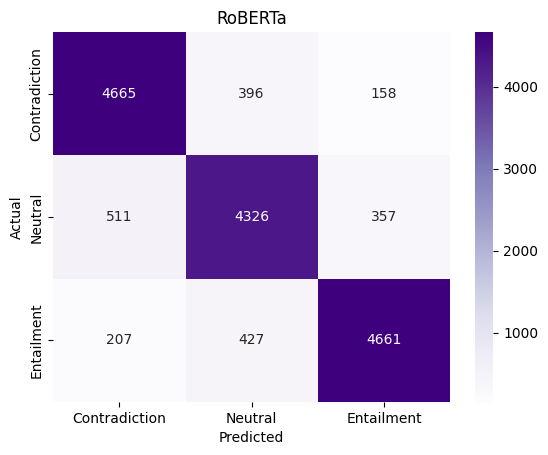

In [44]:
# using heatmap for visualization of confusion matrix

import seaborn as sb
import matplotlib.pyplot as plt

sb.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Contradiction', 'Neutral', 'Entailment'], yticklabels=['Contradiction', 'Neutral', 'Entailment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title('RoBERTa')
plt.show()
